In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
import imageio
import os
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


4.268520458626857
14.520058476328535
[ 1.47198201 -0.          0.        ]
43.5601754289856
[ 4.41485553 -0.          0.83412314]
29.04011695265707
[ 2.69818759 -0.         10.00947764]
0.00000000 0.00000000 20.00000000 1.47198201 -0.00000000 0.00000000 0.00000000 0.00000000 20.00000000 4.41485553 -0.00000000 0.83412314 0.00000000 0.00000000 20.00000000 2.69818759 -0.00000000 10.00947764


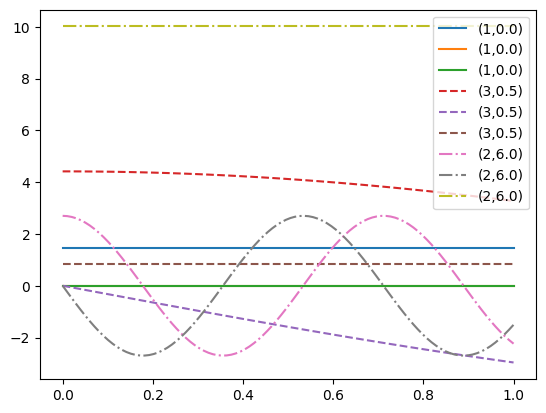

In [2]:
def ang_vel(t,T,Dphi,Dpsi,I_trans,I_long):
    I_ratio = I_trans/I_long
    if np.abs(Dpsi/Dphi) > (np.abs(I_ratio)-1):
        print('The system you provided is in wobbling mode.')
    #print(1/(I_ratio-1)*Dpsi/Dphi)
    theta = np.arcsin(1/(I_ratio-1)*Dpsi/Dphi)
    omega = np.zeros((len(t),3))
    for i in range(len(t)):
        h = Dphi*I_trans/T
        omega[i] = h*np.array([np.cos(theta)*np.cos(Dpsi*t[i]/T)/I_trans,
                             -np.cos(theta)*np.sin(Dpsi*t[i]/T)/I_trans,
                             np.sin(theta)/I_long])
    return omega

def T_from_v0(v0,g=9.81,z0=0):
    return (v0+np.sqrt(v0**2+2*g*z0))/g

def to_plain_str(vec):
    return ' '.join(f"{float(v):.8f}" for v in np.ravel(vec))

v0 = 20
T = T_from_v0(v0,z0=4)
print(T)
m = 7
a = 10
c = 2.5
I_trans = 1/12*m*(c**2+a**2)
I_long = 1/12*m*(2*c**2)
Dphi_ = np.array([1,3,2])
Dpsi_ = np.array([0,0.5,6])
line_ = ['-','--','-.']

t = np.linspace(0,1,100)
qvel_ = []
for i in range(len(Dphi_)):
    h = I_trans*Dphi_[i]/T
    print(h)
    omega = ang_vel(t,T,2*np.pi*Dphi_[i],2*np.pi*Dpsi_[i],I_trans,I_long)
    plt.plot(t,omega,line_[i],label='('+str(Dphi_[i])+','+str(Dpsi_[i])+')')
    qvel_.append([0,0,v0])
    qvel_.append(omega[0])
    print(omega[0])
qvel_attr = to_plain_str(np.concatenate(qvel_))
print(qvel_attr)
plt.legend()

In [3]:
xml= f"""
<mujoco model="rigidbody">
  <option integrator="RK4" gravity="0 0 -9.81"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="500" height="500"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <visual>
    <global offwidth="1920" offheight="1080"/>
  </visual>

  <worldbody>
    <light name="l1" pos="10 0 100"/>
    <light name="l2" pos="40 0 100"/>
    <light name="l3" pos="70 0 100"/>
    <geom pos="0 0 0" size="100 100 0.01" type="plane" material="grid"/>
    <camera name="side_view" pos="132.802 -55.406 57.648" xyaxes="0.522 0.853 0.000 -0.327 0.200 0.924"/>

    <body name="body1" pos="0 0 0">
      <freejoint/>
      <geom type="sphere" density="0" size="1" pos="-2 2.5 10" rgba="0 1 0 1"/>
      <geom type="sphere" density="0" size="1" pos="2 2.5 10" rgba="0 1 0 1"/>
      <geom type="box" mass="7" size="2.5 2.5 10" rgba="0.5 0 0.5 1"/>
    </body>

    <body name="body2" pos="0 0 0">
      <freejoint/>
      <geom type="sphere" density="0" size="1" pos="-2 2.5 10" rgba="0 1 0 1"/>
      <geom type="sphere" density="0" size="1" pos="2 2.5 10" rgba="0 1 0 1"/>
      <geom type="box" mass="7" size="2.5 2.5 10" rgba="0.5 0 0.5 1"/>
    </body>

    <body name="body3" pos="0 0 0">
      <freejoint/>
      <geom type="sphere" density="0" size="1" pos="-2 2.5 10" rgba="0 1 0 1"/>
      <geom type="sphere" density="0" size="1" pos="2 2.5 10" rgba="0 1 0 1"/>
      <geom type="box" mass="7" size="2.5 2.5 10" rgba="0.5 0 0.5 1"/>
    </body>

  </worldbody>

  <keyframe>
    <key name="precession"
        qpos="10 0 15 1 0 0 0    40 0 15 1 0 0 0     70 0 15 1 0 0 0"
        qvel="{qvel_attr}"/>
  </keyframe>
</mujoco>
"""

In [4]:
m = mujoco.MjModel.from_xml_string(xml)
d = mujoco.MjData(m)

In [5]:
import mujoco.viewer
import time

mujoco.mj_resetDataKeyframe(m, d, 0)
print(d.qvel)

with mujoco.viewer.launch_passive(m, d) as viewer:
    # --- options (mjvOption) ---
    viewer.opt.frame = mujoco.mjtFrame.mjFRAME_WORLD

    # --- camera selection ---
    cam_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_CAMERA, "side_view")
    viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
    viewer.cam.fixedcamid = cam_id

    # --- simulation loop ---
    while viewer.is_running():
        start = time.time()
        while viewer.is_running() and time.time() - start < 8:
            mujoco.mj_step(m, d)
            viewer.sync()
            time.sleep(m.opt.timestep)
        mujoco.mj_resetDataKeyframe(m, d, 0)

[ 0.          0.         20.          1.47198201 -0.          0.
  0.          0.         20.          4.41485553 -0.          0.83412314
  0.          0.         20.          2.69818759 -0.         10.00947764]


/home/yugiero/tma_env/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65548) b'Wayland: The platform does not provide the window position'
  warnings.warn(message, GLFWError)


In [6]:

duration = 7
framerate = 60

frames = []
mujoco.mj_resetDataKeyframe(m, d, 0)  # Reset the state to keyframe 0
with mujoco.Renderer(m,width=1920,height=1080) as renderer:
  while d.time < duration:
    mujoco.mj_step(m, d)
    if len(frames) < d.time * framerate:
      renderer.update_scene(d,'side_view')
      pixels = renderer.render()
      frames.append(pixels)

#media.show_video(frames, fps=framerate)

output_path = "output.mp4"
imageio.mimsave(output_path, frames, fps=framerate)

def open_video(path):
    os.system(f"xdg-open {path}")

open_video("output.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[00005fa148747580] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.


In [7]:
'''
from mujoco.usd import exporter

m = mujoco.MjModel.from_xml_string(xml)
d = mujoco.MjData(m)

duration = 7
framerate = 60

exp = exporter.USDExporter(model=m)

while d.time < duration:
    mujoco.mj_step(m, d)
    if exp.frame_count < d.time * framerate:
        exp.update_scene(data=d)
        exp.save_scene(filetype='usd')
'''

"\nfrom mujoco.usd import exporter\n\nm = mujoco.MjModel.from_xml_string(xml)\nd = mujoco.MjData(m)\n\nduration = 7\nframerate = 60\n\nexp = exporter.USDExporter(model=m)\n\nwhile d.time < duration:\n    mujoco.mj_step(m, d)\n    if exp.frame_count < d.time * framerate:\n        exp.update_scene(data=d)\n        exp.save_scene(filetype='usd')\n"